## Model Performance for ABM Data

All models are trained on data from fall 2016, 2017 and 2018. Hyperparameters have been tuned using data from fall 2019.

The final model performance is evaluated on data from fall 2015.

Model performance is quantified using the Root Mean-Squared Error (RMSE), where only available timepoints during the night are considered.

### Overview of models
#### **Site-specific**

Site-specific models are different for every radar station.
- Historical average (HA), bird density at radar station averaged over training years
- Generalized additive Models (GAM) based on `day of the year`, `solar position` and `change in solar position`

#### **Local models**

Local models don't take spatial or temporal dependencies into account:

- Gradient Boosted Regression Trees (GBT)
- Multi-Layer Perceptron (MLP)

$$\hat{y}_i^{(t_0+t)} = f_{\text{local}}(\mathbf{X}_i^{(t_0+t)}; \theta_{\text{local}}) \quad \forall t \in \{1,...,H\}$$

Features used: `radar coordinates`, `Voronoi area`, `u & v wind component`, `cloud cover`, `total precipitation`, `surface pressure`, `surface temperature`, `sensible heat flux`

#### **Temporal models**

Temporal models are recurrent models that predict future bird densities based on previous timesteps, but don't take spatial dependencies into account:
    
- Long-Short Term Memory (LocalLSTM)

$$\mathbf{h}_i^{(t_0+t)} = g_{\text{RNN}}(\mathbf{h}_i^{(t_0+t-1)}, \mathbf{X}_i^{(t_0+t)}; \theta_{\text{recurrent}}) \quad \forall t \in \{1,...,H\}$$

$$\hat{y}_i^{(t_0+t)} = o(\mathbf{h}_i^{(t_0+t)}; \theta_{\text{output}}) \quad \forall t \in \{1,...,H\}$$

Additional features used: `dusk (boolean)`, `dawn (boolean)`, `bird density at previous timestep`

#### **Spatio-temporal models**

Spatio-temporal models take both spatial and temporal dependencies into account
- graph neural network based on Voronoi tessellation with recurrent component (GraphLSTM)
    - prediction = `bird density at previous timestep` + `delta` + `total flux from/to neighbors`
    
    $$\hat{y}_i^{(t_0+t)}=\hat{y}_i^{(t_0+t-1)} + \Phi_v(\mathbf{h}_i^{(t_0+t-1)}, \mathbf{X}_{i}^{(t_0+t)}; \theta_{v}) + \rho_{v\rightarrow e}\left(\sum_{j\in \mathcal{N}(i)\cup \{j\}} \Phi_e(\mathbf{X}_i^{(t_0+t)}, \mathbf{X}_j^{(t_0+t)}; \theta_{e}); \theta_{e\rightarrow v}\right)$$
    
- graph neural network based on Voronoi tessellation with recurrent component and explicitly modelled bird flows between adjacent radar stations (BirdFlowGraphLSTM)
    - prediction = `delta` + `sum of in-fluxes from neighbors` + `flux to self`
    
    $$\hat{y}_i^{(t_0+t)}=\Phi_v(\mathbf{h}_i^{(t_0+t-1)}, \mathbf{X}_{i}^{(t_0+t)}; \theta_{v}) + \sum_{j\in \mathcal{N}(i)\cup \{j\}} \Phi_e(\mathbf{X}_i^{(t_0+t)}, \mathbf{X}_j^{(t_0+t)}; \theta_{e}) \cdot \hat{y}_j^{(t_0+t-1)}$$

Features for spatial component: `radar coordinates`, `environment variables (see above)`, `radar distance`, `radar angle`, `length of Voronoi face`, `bird density at previous timestep`

Features for temporal component: `radar coornidates`, `environment variables (see above)`, `dusk (boolean)`, `dawn (boolean)`, `Voronoi area`, `bird density at previous timestep`

![alt text](../data/plots/presentations/GNN_overview.png "Spatio-Temporal Graph Neural-Net")

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import geopandas as gpd
import networkx as nx

In [2]:
base_dir = '/home/fiona/birdMigration/results/abm'

### Load Results

In [3]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'BirdFlowGraphLSTM', 'GraphLSTM']
experiments = ['', '', '_not_transformed', '_not_transformed', '_new', '_new', '_new']
results = dict()
bird_scales = dict()
for i, m in enumerate(models):
    if m in ['HA', 'GAM']:
        experiment = 'radar_specific'
    else:
        experiment = 'best_settings' + experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales[m] = cfg['datasource']['bird_scale']
    
    # load outfluxes
    if m == 'BirdFlowGraphLSTM':
        files = glob.glob(model_dir + "/**/outfluxes_abs_*.pickle", recursive = True)
        outfluxes = dict()
        for r, file in enumerate(files):
            with open(file, 'rb') as f:
                outfluxes[r] = pickle.load(f)
        fp = glob.glob(model_dir + "/**/radar_index.pickle", recursive = True)[0]
        with open(fp, 'rb') as f:
            radar_index = pickle.load(f)

### Load results for models trained on data from radar buffers

In [4]:
models = ['HA', 'GAM', 'GBT', 'LocalMLP', 'LocalLSTM', 'BirdFlowGraphLSTM', 'GraphLSTM']
experiments = ['', '', '_not_transformed_use_buffers', '_not_transformed_use_buffers', '_use_buffers', '_use_buffers', '_use_buffers']
results_buffers = dict()
bird_scales_buffers = dict()
for i, m in enumerate(models):
    if m in ['HA', 'GAM']:
        experiment = 'radar_specific'
    else:
        experiment = 'best_settings' + experiments[i]
    
    # load predictions
    model_dir = osp.join(base_dir, 'testing', m, experiment)
    files = glob.glob(model_dir + "/**/results.csv", recursive = True)
    results_buffers[m] = pd.read_csv(files[0])
    
    # load bird scales
    fp = osp.join(base_dir, 'training', m, experiment, 'config.yaml')
    with open(fp) as f:
        cfg = load(f, Loader=Loader)
    bird_scales_buffers[m] = cfg['datasource']['bird_scale']

### Radar observations vs. predicted bird density for **raw data**

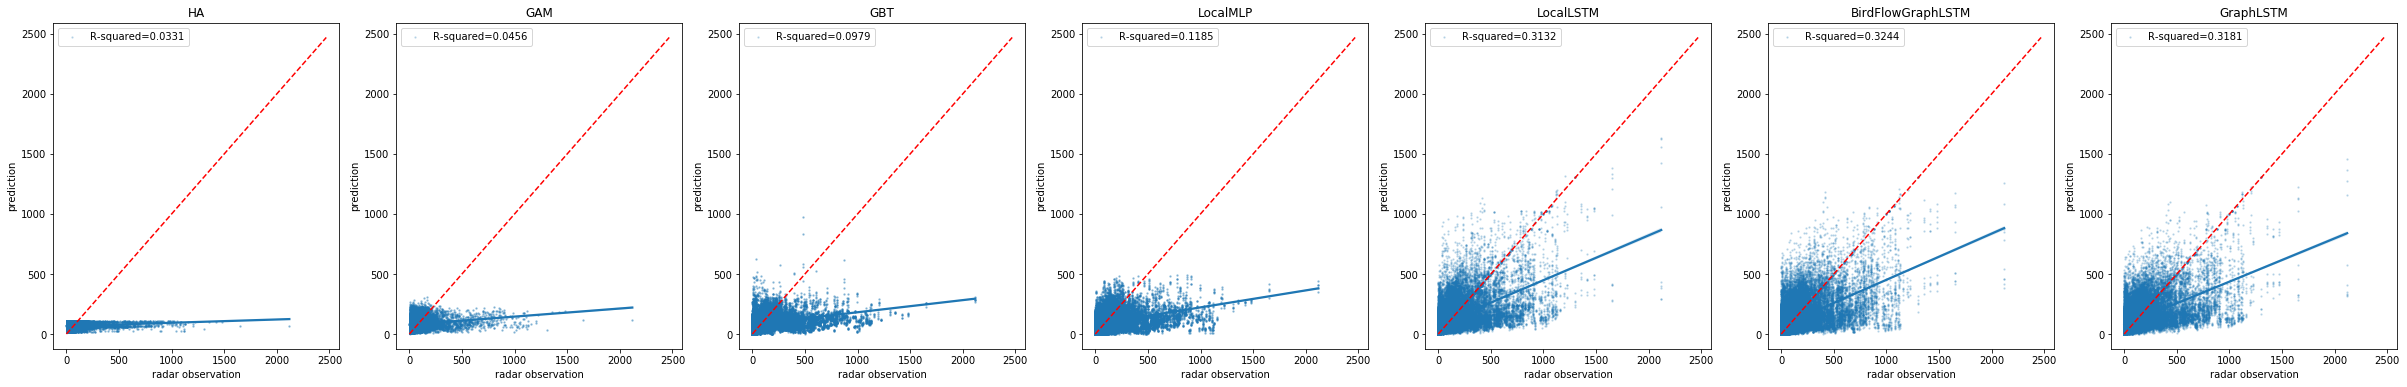

In [44]:
fig = utils.plot_results_scatter(results, max=max(bird_scales.values()), legend=True)

### Radar observations vs. predicted bird density for **power-transformed data with exponent p=1/3**

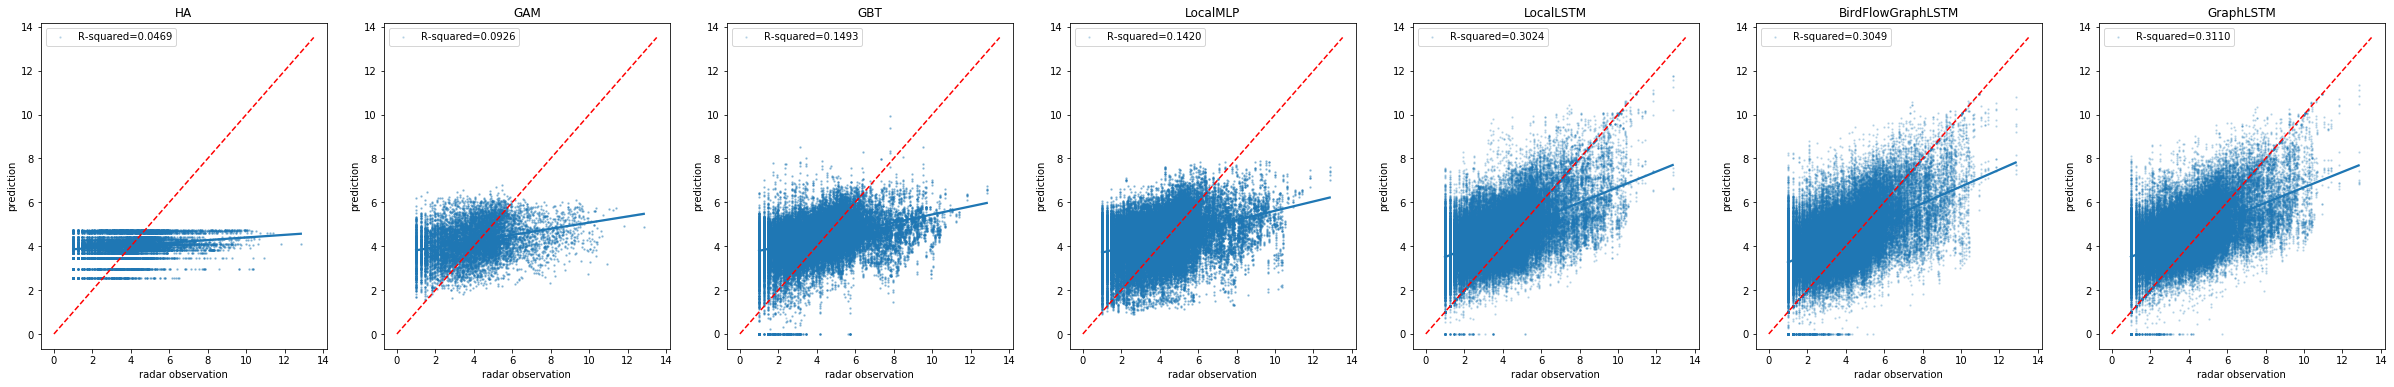

In [45]:
fig = utils.plot_results_scatter(results, root_transform=3, max=max(bird_scales.values()), legend=True)

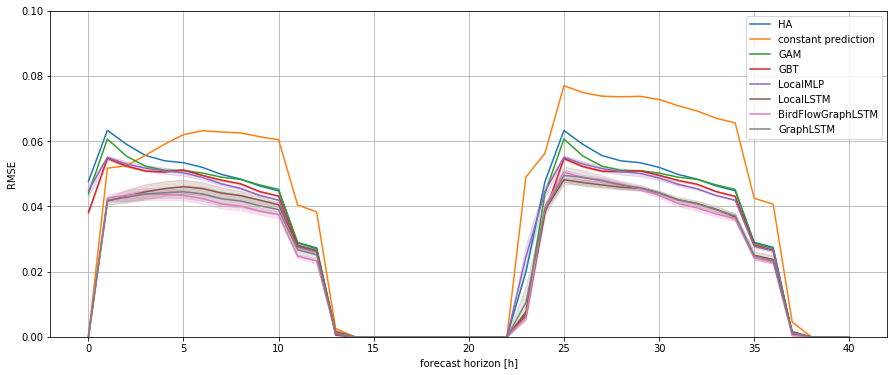

In [5]:
fig = utils.plot_errors(results, bird_scales)

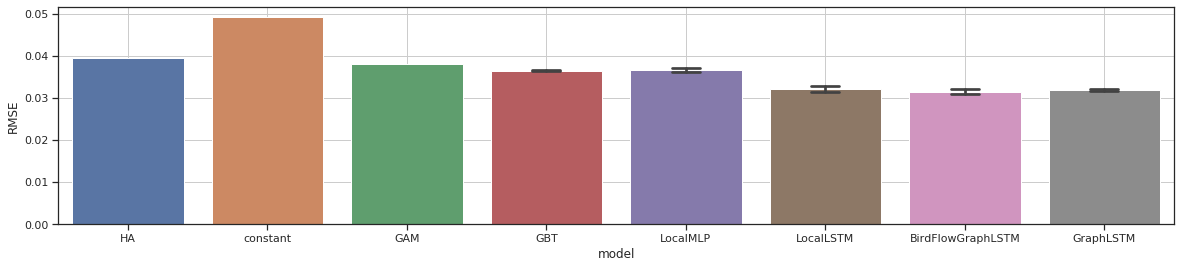

In [6]:
fig = utils.plot_average_errors(results, bird_scales)

### Comparing predictions of models trained on buffer data with ground truth bird density in Voronoi cells

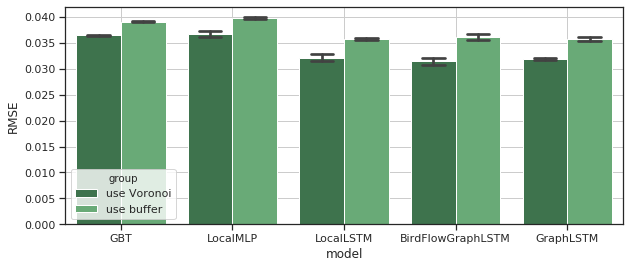

In [7]:
fig = utils.plot_average_errors_comparison(['GBT', 'LocalMLP', 'LocalLSTM', 'BirdFlowGraphLSTM', 'GraphLSTM',], 
                                           results, results_buffers, bird_scales, bird_scales_buffers, 
                                           ['use Voronoi', 'use buffer'])

Error bars show the standard deviation in RMSE over 5 repeatedly trained models using different random seeds

## Analysis of BirdFlowGraphLSTM
### Inferred outflux per radar station
The outflux per radar station should equal to 1 at each timestep if no birds are landing and thus moving from the air to the ground.

[Text(0, 0.5, 'total outflux')]

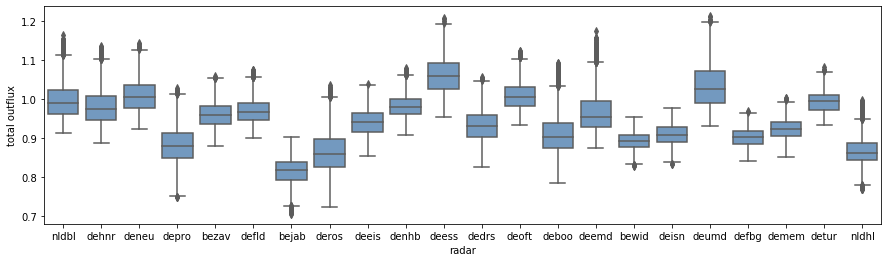

In [15]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.boxplot(x='radar', y='outflux', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc') #, ci='sd')
ax.set(ylabel='total outflux')

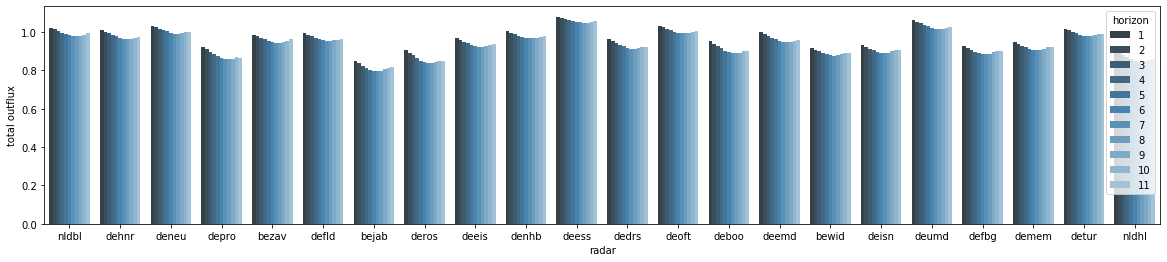

In [16]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='outflux', hue='horizon', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total outflux');

### Inferred number of birds taking off / landing per radar station
If delta < 0, more birds are landing than taking off. Otherwise, more birds are taking off.

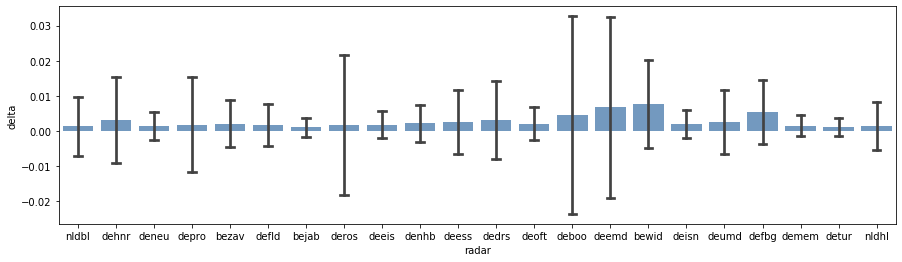

In [17]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.barplot(x='radar', y='delta', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc', capsize=.2, ci='sd')

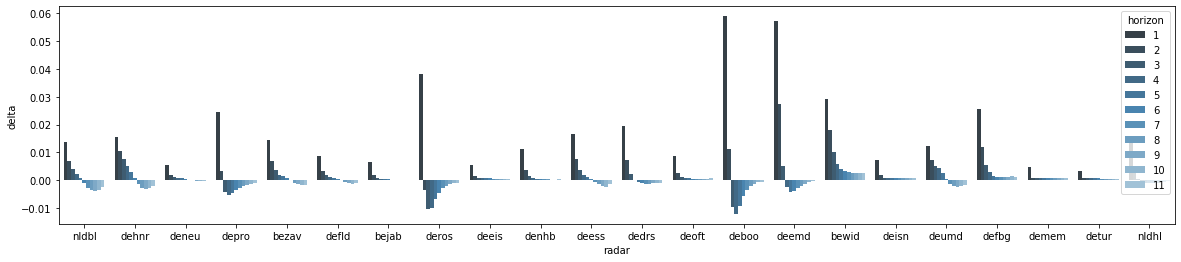

In [19]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='delta', hue='horizon', data=results['BirdFlowGraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='delta');

## Analysis of GraphLSTM
### Inferred total flux from/to neighbors per radar station

[Text(0, 0.5, 'total flux from/to neighbors')]

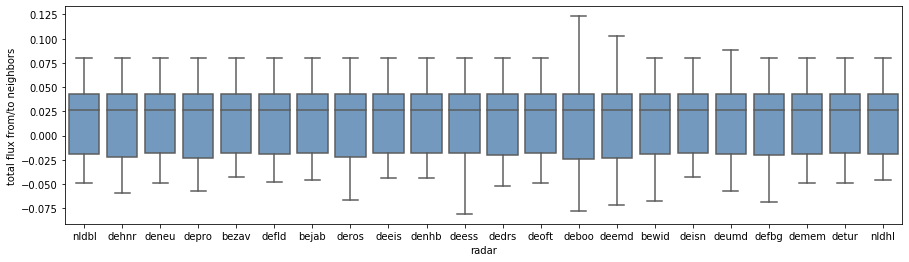

In [21]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.boxplot(x='radar', y='fluxes', data=results['GraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc') #, ci='sd')
ax.set(ylabel='total flux from/to neighbors')

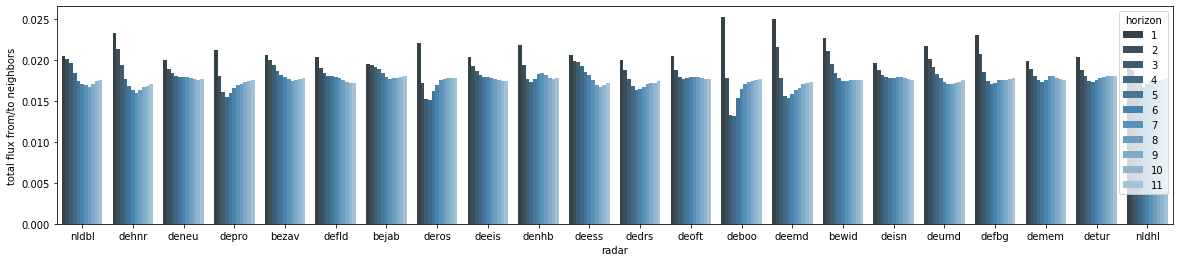

In [22]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='fluxes', hue='horizon', data=results['GraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='total flux from/to neighbors');

### Inferred take-off/landing

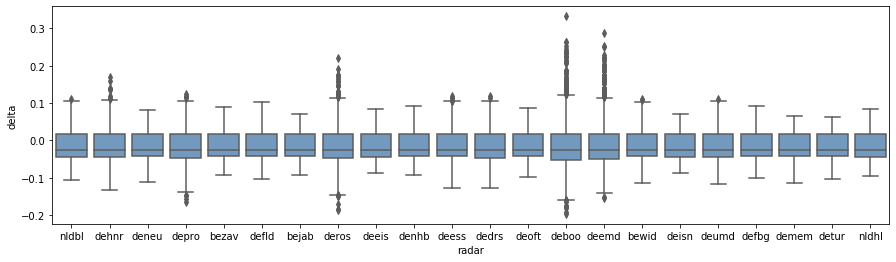

In [41]:
fig, ax = plt.subplots(figsize=(15, 4))
sb.boxplot(x='radar', y='local_deltas', data=results['GraphLSTM'].query('night == True & horizon != 0'), ax=ax, color='#6699cc')#, capsize=.2, ci='sd')
ax.set(ylabel='delta');

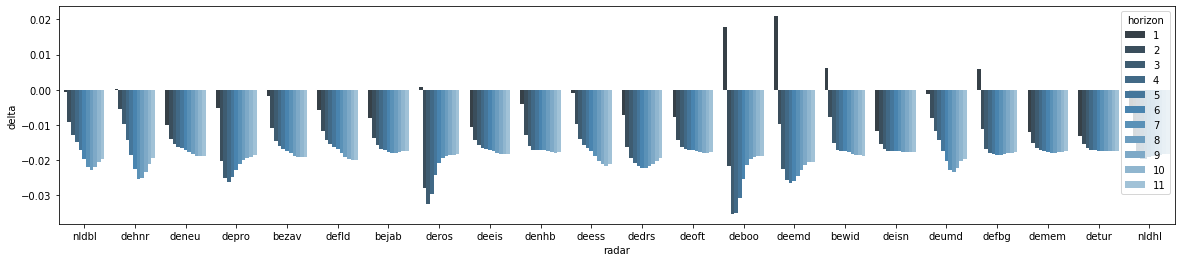

In [24]:
fig, ax = plt.subplots(figsize=(20, 4))
sb.barplot(x='radar', y='local_deltas', hue='horizon', data=results['GraphLSTM'].query('night == True & horizon != 0 & horizon < 12'), 
           ax=ax, ci=None, palette="Blues_d")
ax.set(ylabel='delta');

### Compare inferred fluxes to simulated fluxes

In [35]:
abm_path = '/home/fiona/birdMigration/data/raw/abm/fall/2015'
voronoi = gpd.read_file('/home/fiona/birdMigration/data/raw/radar/fall/2015/voronoi.shp').to_crs(epsg='4326')
N = len(voronoi)

model = 'BirdFlowGraphLSTM'
ml_results = results[model]
print(ml_results.radar.unique())
outfluxes_abs = outfluxes[0] # use only one trial

ml_fluxes = []
abm_fluxes = []

for i, row in ml_results.query('radar == "dehnr" & trial == 0').iterrows():
    nidx = row.seqID
    tidx = row.tidx
    if row.night and tidx > 0:
        ml_fluxes.append(outfluxes_abs[nidx][:, :, row.horizon].detach().numpy())
        abm_fluxes.append(np.load(osp.join(abm_path, 'outfluxes_abs', f'{tidx-1}.npy'))[:N, :N])
    
ml_fluxes = np.stack(ml_fluxes, axis=-1) * bird_scales[model]

# reindex flux matrix to match radar order of abm data
radar_index = {r: idx for idx, r in radar_index.items()}
ridx = np.array([radar_index[r] for r in voronoi.radar])
ml_fluxes = ml_fluxes[ridx, :, :]
ml_fluxes = ml_fluxes[:, ridx, :]

abm_fluxes = np.stack(abm_fluxes, axis=-1)

['nldbl' 'dehnr' 'deneu' 'depro' 'bezav' 'defld' 'bejab' 'deros' 'deeis'
 'denhb' 'deess' 'dedrs' 'deoft' 'deboo' 'deemd' 'bewid' 'deisn' 'deumd'
 'defbg' 'demem' 'detur' 'nldhl']


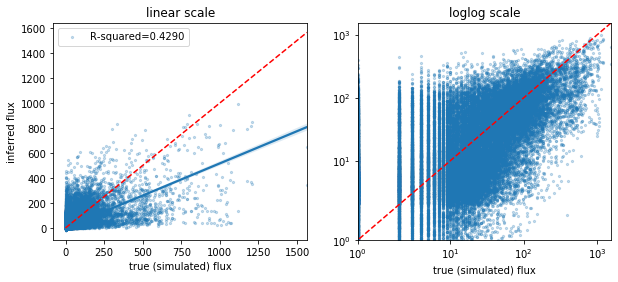

In [40]:
max_flux = max(ml_fluxes.max(), abm_fluxes.max())
res = sp.stats.linregress(abm_fluxes.flatten(), ml_fluxes.flatten())

fig, ax = plt.subplots(1, 2, figsize=(10, 4))    
sb.regplot(abm_fluxes.flatten(), ml_fluxes.flatten(), scatter=True, ci=95, label=f'R-squared={res.rvalue**2:.4f}', scatter_kws={'alpha':0.25, 's':5}, ax=ax[0])
#sb.regplot(abm_fluxes.flatten(), ml_fluxes.flatten(), scatter=True, ci=95, ax=ax, label=f'R-squared={res.rvalue**2:.4f}', scatter_kws={'alpha':0.25, 's':5}, ax=ax[1])
ax[1].scatter(abm_fluxes.flatten(), ml_fluxes.flatten(), alpha=0.25, s=5)
ax[0].plot(range(int(max_flux)), range(int(max_flux)), ls='--', c='red')
ax[1].plot(range(int(max_flux)), range(int(max_flux)), ls='--', c='red')
ax[0].set(title='linear scale', xlabel='true (simulated) flux', ylabel='inferred flux')#, xlim=(0-margin,max_flux_boundary+margin), ylim=(0-margin,max_flux_boundary+margin))
ax[1].set(title='loglog scale', xlabel='true (simulated) flux', xlim=(1,max_flux), ylim=(1,max_flux))
ax[1].set(yscale='symlog', xscale='symlog')
ax[0].legend();

In [15]:
abm_path = '/home/fiona/birdMigration/data/raw/abm/fall/2015'
radar_path = '/home/fiona/birdMigration/data/raw/radar/fall/2015'
voronoi = gpd.read_file(osp.join(radar_path, 'voronoi.shp')).to_crs(epsg='4326')
G = nx.read_gpickle(osp.join(radar_path, 'delaunay.gpickle'))

In [71]:
departing_birds = np.load(osp.join(abm_path, 'departing_birds.npy'))
landing_birds = np.load(osp.join(abm_path, 'landing_birds.npy'))

model = 'BirdFlowGraphLSTM'
ml_results = results[model]

ml_deltas = np.zeros((ml_results.tidx.max()+1, len(voronoi)))
abm_deltas = np.zeros((ml_results.tidx.max()+1, len(voronoi)))


for tidx in range(ml_results.tidx.max()+1):
    for i, radar in enumerate(voronoi.radar.values):
        data_r = ml_results.query(f'tidx == {tidx} & radar == "{radar}"')
        abm_deltas[tidx, i] = departing_birds[tidx, i] - landing_birds[tidx, i]
        ml_deltas[tidx, i] = data_r.delta.mean() * bird_scales[model]
    

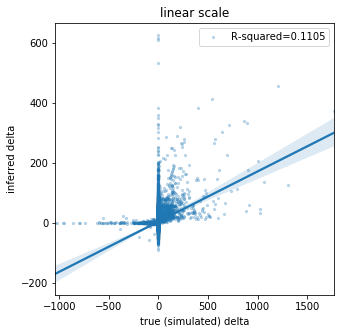

In [43]:
mask = np.where(abm_deltas == 0)
max_delta = max(ml_deltas.max(), abm_deltas.max())
res = sp.stats.linregress(abm_deltas[mask].flatten(), ml_deltas[mask].flatten())

fig, ax = plt.subplots(figsize=(5, 5))    
sb.regplot(abm_deltas[mask].flatten(), ml_deltas[mask].flatten(), scatter=True, ci=95, label=f'R-squared={res.rvalue**2:.4f}', scatter_kws={'alpha':0.25, 's':5}, ax=ax)
ax.set(xlabel='true (simulated) delta', ylabel='inferred delta')#, xlim=(0-margin,max_flux_boundary+margin), ylim=(0-margin,max_flux_boundary+margin))
ax.legend();

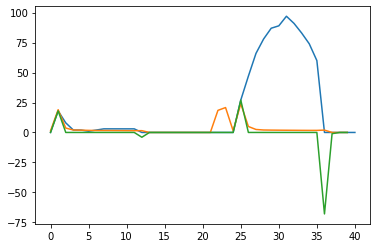

In [69]:
nidx = 35
data_r = results[model].query(f'radar == "{voronoi.iloc[0].radar}" & seqID == {nidx} & trial == 0')
start = data_r.tidx.min()
plt.plot(data_r['gt'].values)
plt.plot(ml_deltas[start:start+40, 0])
plt.plot(abm_deltas[start:start+40, 0])

In [47]:
ml_results

,Unnamed: 0,gt,prediction,night,radar,seqID,tidx,datetime,trial,horizon,missing,outflux,delta,selfflux,influx
0,0,0.0,0.000000,True,nldbl,0,7,2015-09-01 19:00:00+00:00,0,0,False,0.000000,0.000000,0.000000,0.000000
1,1,0.0,8.310720,True,nldbl,0,8,2015-09-01 20:00:00+00:00,0,1,False,0.994046,0.003365,0.000000,0.000000
2,2,1.0,8.760919,True,nldbl,0,9,2015-09-01 21:00:00+00:00,0,2,False,0.987715,0.000447,0.002521,0.000580
3,3,1.0,9.582809,True,nldbl,0,10,2015-09-01 22:00:00+00:00,0,3,False,0.980557,0.000447,0.002615,0.000818
4,4,1.0,10.541723,True,nldbl,0,11,2015-09-01 23:00:00+00:00,0,4,False,0.973049,0.000447,0.002847,0.000974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270595,270595,0.0,14.725216,True,nldhl,59,1457,2015-11-01 05:00:00+00:00,4,36,False,0.846273,0.000594,0.004396,0.000972
270596,270596,0.0,15.351967,True,nldhl,59,1458,2015-11-01 06:00:00+00:00,4,37,False,0.860096,0.000694,0.004492,0.001029
270597,270597,0.0,0.000000,False,nldhl,59,1459,2015-11-01 07:00:00+00:00,4,38,False,0.000000,0.000000,0.000000,0.000000
270598,270598,0.0,0.000000,False,nldhl,59,1460,2015-11-01 08:00:00+00:00,4,39,False,0.000000,0.000000,0.000000,0.000000


In [22]:
x_eqa = voronoi.x_eqa.values
y_eqa = voronoi.y_eqa.values

thr = 108 * 2

coords = np.stack([x_eqa, y_eqa], axis=-1)
for i, ri in enumerate(voronoi.radar.values):
    for j, rj in enumerate(voronoi.radar.values):
        dist = np.linalg.norm(coords[i] - coords[j]) / 1000
        if dist < thr and dist > 0:
            print(ri, rj, dist)

demem deisn 140.93143805565657
demem detur 68.45832454485091
demem defbg 166.6875177644123
deisn demem 140.93143805565657
deisn detur 177.78593712335103
deisn deeis 153.47766396538154
deess deoft 200.44921238468163
deess bezav 184.27214651251688
deess denhb 147.14968461914486
deess bewid 195.40661179379896
deess defld 128.24555726995774
deess deemd 215.25221277251973
deess nldbl 145.76706810479956
depro deumd 190.3980806807475
depro deros 207.8928196131271
depro dedrs 169.70624259764347
deoft deess 200.44921238468163
deoft detur 174.08482860981007
deoft deneu 181.92857353491817
deoft denhb 155.71212906621395
deoft defld 147.55176423272397
detur demem 68.45832454485091
detur deisn 177.78593712335103
detur deoft 174.08482860981007
detur defbg 154.04602028240788
deumd depro 190.3980806807475
deumd deneu 184.70267773771525
deumd dehnr 106.41636999873342
deumd defld 189.2397807840529
deumd dedrs 213.2278704251846
bezav deess 184.27214651251688
bezav denhb 172.9037846058147
bezav bewid 133.2

In [21]:
108 * 8

864

In [20]:
for e in G.edges(data=True):
    print(e)

(0, 1, {'distance': 140.85968493077044, 'face_length': 196.68350345171422, 'angle': 85.99747874559216})
(0, 5, {'distance': 68.47528667199421, 'face_length': 165.12134226794888, 'angle': 321.0920895728429})
(0, 9, {'distance': 166.60807069214636, 'face_length': 127.14052237796083, 'angle': 265.62736803732787})
(1, 0, {'distance': 140.85968493077044, 'face_length': 196.68350345171422, 'angle': 265.99747874559216})
(1, 5, {'distance': 177.73634969112516, 'face_length': 30.679257306421388, 'angle': 280.0402394036082})
(1, 8, {'distance': 153.50140046706312, 'face_length': 208.0596302022959, 'angle': 12.427373484015675})
(5, 0, {'distance': 68.47528667199421, 'face_length': 165.12134226794888, 'angle': 141.09208957284295})
(5, 1, {'distance': 177.73634969112516, 'face_length': 30.679257306421388, 'angle': 100.04023940360821})
(5, 4, {'distance': 174.09727730618042, 'face_length': 163.50480262775545, 'angle': 322.65322253616006})
(5, 8, {'distance': 218.95436316901717, 'face_length': 63.118

In [23]:
voronoi

,radar,x,y,x_eqa,y_eqa,lon,lat,boundary,geometry
0,demem,100161.213331,-330545.407677,4.337444e+06,2.769967e+06,10.220420,48.043060,1,"POLYGON ((9.29495 46.85027, 9.10643 47.98666, ..."
1,deisn,239812.932299,-311631.296412,4.477367e+06,2.786798e+06,12.101770,48.174700,1,"POLYGON ((11.34114 46.92995, 11.06864 48.68936..."
2,deess,-132940.264869,44270.652352,4.110018e+06,3.148242e+06,6.966944,51.405556,0,"POLYGON ((5.63063 51.30777, 6.71487 52.37543, ..."
3,depro,336845.421495,192326.623074,4.581966e+06,3.289091e+06,13.857810,52.648570,1,"POLYGON ((12.75334 51.90547, 12.18092 53.07667..."
4,deoft,-11739.002630,-115366.625934,4.228765e+06,2.986753e+06,8.713970,49.985920,0,"POLYGON ((7.71313 50.62914, 7.79603 50.67043, ..."
5,detur,66796.804848,-270746.671119,4.304968e+06,2.830232e+06,9.782780,48.585280,0,"POLYGON ((11.06864 48.68936, 9.10643 47.98666,..."
6,deumd,157273.184072,128961.843315,4.401479e+06,3.228463e+06,11.176090,52.160090,0,"POLYGON ((10.07776 51.63380, 10.89515 53.14358..."
7,bezav,-310903.581534,-3760.139838,3.931385e+06,3.103004e+06,4.455000,50.905499,1,"POLYGON ((3.15324 49.84687, 4.08818 51.67166, ..."
8,deeis,255069.979215,-158844.116141,4.494901e+06,2.939271e+06,12.402780,49.540660,1,"POLYGON ((10.75523 49.45161, 12.63825 50.48735..."
9,defbg,-65397.198004,-349908.652774,4.171609e+06,2.753124e+06,8.003860,47.873570,1,"POLYGON ((6.41106 48.70305, 6.56487 48.78579, ..."
